In [1]:
from __future__ import print_function, division

In [662]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import qgrid

import numpy as np
from numpy import diff
import math

import pandas as pd
import xarray as xr

import climlab
from climlab.solar.insolation import daily_insolation
from climlab.radiation import DailyInsolation
from climlab.radiation import FixedInsolation
from climlab.process import TimeDependentProcess
from climlab.utils import heat_capacity


from IPython.display import HTML


import scipy as scp
from attrdict import AttrDict
from datetime import datetime

import dask.dataframe as dd

import warnings

import util
import ram_model
import plotting

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Data

Read data and concatenate into one dataset.

level 0 = Surface

level 110 = TOA

(our data is in the order TOA-->Surface)

In [3]:
ds = util.load_soundings()
util.add_monthly_insolation(ds)
ds = util.adjust_lev(ds)

Dropped levels [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 22, 23, 24, 25, 26, 27, 28, 29]


# Climlab

All tendencies must be in K/sec (see Climlab energy_budget documentation and self.heating_rate attribute): https://climlab.readthedocs.io/en/latest/_modules/climlab/process/energy_budget.html#EnergyBudget

In [10]:
#### Find the surface diffk average over 12 months at CO2 = .00038 ####
timestep = 3600 #seconds
ram_dict_annual_mean_diffk = {}
ram_dict_annual_mean_diffk = ram_model.fill_ensemble(ds, ram_dict_annual_mean_diffk, timestep, surface_diffk = None)
surface_diffk_average = ram_model.annual_mean_sfc_diffk(ds, ram_dict_annual_mean_diffk)

In [651]:
#### Find our initial output for the model with a set average surface diffk #### 
ram_dict = {}
ram_dict = ram_model.fill_ensemble(ds, ram_dict, timestep, surface_diffk = .4)

# Output (initial and over time)

### Initial

In [652]:
###set up lists and variables
diagnostics_list = list(ram_dict[.0001]['January'].diagnostics.keys())
temp_list = ['Ts','Tatm']
adv_dict = {'advection_Ts':'Ts','advection_Tatm':'Tatm'}
output_list = temp_list + diagnostics_list + list(adv_dict.keys()) + ['lev_bounds'] + ['time']
print('Outputs available ' + str(output_list))
print('CO2 values ' + str(ds['CO2_list'].values))
print('timestep ' + str(timestep) + ' seconds')


Outputs available ['Ts', 'Tatm', 'OLR', 'OLRclr', 'OLRcld', 'TdotLW', 'TdotLW_clr', 'LW_sfc', 'LW_sfc_clr', 'LW_flux_up', 'LW_flux_down', 'LW_flux_net', 'LW_flux_up_clr', 'LW_flux_down_clr', 'LW_flux_net_clr', 'ASR', 'ASRclr', 'ASRcld', 'TdotSW', 'TdotSW_clr', 'SW_sfc', 'SW_sfc_clr', 'SW_flux_up', 'SW_flux_down', 'SW_flux_net', 'SW_flux_up_clr', 'SW_flux_down_clr', 'SW_flux_net_clr', 'total_sfc_flux_init', 'theta_init', 'dtheta_dz_surf_init', 'surface_diffk', 'theta', 'dtheta_dz', 'atm_diffk', 'atm_turbulent_flux', 'sfc_turbulent_flux', 'atm_hr', 'sfc_hr', 'hr', 'z', 'z_bounds', 'advection_Ts', 'advection_Tatm', 'lev_bounds', 'time']
CO2 values [0.0001  0.0002  0.00038 0.00076 0.001   0.0015 ]
timestep 3600 seconds


In [653]:
### create dictionary for results
results_dict = {}

In [654]:
### results at first timestep
results_dict[0] = {}
for output in output_list:
    results_dict[0][output] = {}
    for CO2 in ds['CO2_list'].values:
        results_dict[0][output][CO2] = {}
        for m in np.asarray(ds['month']):
            results_dict[0][output][CO2][m] = {}
            if output in (diagnostics_list):
                results_dict[0][output][CO2][m] = (ram_dict[CO2][m].diagnostics[output])
            if output in temp_list:
                results_dict[0][output][CO2][m] = list(ram_dict[CO2][m].state[output])
            if output in list(adv_dict.keys()):
                results_dict[0][output][CO2][m] = list(ram_dict[CO2][m].subprocess.Advection.forcing_tendencies[adv_dict[output]])
            if output == 'lev_bounds':
                results_dict[0][output][CO2][m] = list(ram_dict[CO2][m].lev_bounds)
            if output == 'time':
                results_dict[0]['time'][CO2][m] = list(ram_dict[CO2][m].time)


### Timestep forward

In [655]:
steps = 2190
### results for each timestep
for i in range(steps):
    #step model forward
    results_dict[(i+1)*timestep] = {}
    for count, output in enumerate(output_list):
        results_dict[(i+1)*timestep][output] = {}
        for CO2 in ds['CO2_list'].values:
            results_dict[(i+1)*timestep][output][CO2] = {}
            for m in np.asarray(ds['month']):
                results_dict[(i+1)*timestep][output][CO2][m] = {}
                if count==0:
                    ram_dict[CO2][m].step_forward()
                #add outputs/diagnostics
                if output in (diagnostics_list):
                    results_dict[(i+1)*timestep][output][CO2][m] = (ram_dict[CO2][m].diagnostics[output])
                if output in temp_list:
                    results_dict[(i+1)*timestep][output][CO2][m] = list(ram_dict[CO2][m].state[output])
                if output in list(adv_dict.keys()):
                    results_dict[(i+1)*timestep][output][CO2][m] = list(ram_dict[CO2][m].subprocess.Advection.forcing_tendencies[adv_dict[output]])
                if output == 'lev_bounds':
                    results_dict[(i+1)*timestep][output][CO2][m] = list(ram_dict[CO2][m].lev_bounds)

#### parameters for plots

In [656]:
###select CO2 concentrations and times to look at
CO2_conc1 = .00038
CO2_conc2 = .00076
time1 = (0)*timestep
time2 = (480)*timestep
time3 = (steps/2)*timestep
time4 = steps*timestep
month1 = 'December'
month2 = 'June'

###create a dict of output names and the z bounds they align with
output_dict = {}
output_dict['bounds'] = {'Tatm':'z','TdotLW_clr':'z', 'LW_flux_up_clr':'z_bounds', 
               'LW_flux_down_clr':'z_bounds', 'LW_flux_net_clr':'z_bounds', 
               'TdotSW_clr':'z', 'SW_flux_up_clr':'z_bounds', 
               'SW_flux_down_clr':'z_bounds', 'SW_flux_net_clr':'z_bounds',
               'theta_init':'z', 'theta':'z', 'dtheta_dz':'z_bounds', 'atm_diffk':'z_bounds', 
               'atm_turbulent_flux':'z_bounds','atm_hr':'z', 
               'hr':'z', 'advection_Tatm':'z'}
atm_process_dict = {'Tatm':'Atmospheric Temperature (K)',
                    'atm_diffk':r'Atmospheric $\kappa$ ($\frac{m^2}{s}$)',
                    'dtheta_dz':r'$\frac{d\theta}{dz}$ ($\frac{K}{m}$)',
                    'theta':r'$\theta$',
                    'SW_flux_net_clr':r'Shortwave Flux ($\frac{W}{m^2}$)',
                    'LW_flux_net_clr':r'Longwave Flux ($\frac{W}{m^2}$)', 
                    'TdotLW_clr':r'Longwave Heating Rate ($\frac{K}{s}$)',
                    'TdotSW_clr':r'Shortwave Heating Rate ($\frac{K}{s}$)',
                    'atm_hr':r'Turbulent Heating Rate ($\frac{K}{s}$)',
                    'advection_Tatm':r'Advective Heating Rate ($\frac{K}{s}$)'}
single_level_process = {'LW_sfc_clr':r'Surface Longwave Flux ($\frac{W}{m^2}$)', 
                        'Ts': 'Surface Temperature (K)', 
                        'ASRclr':r'Absorbed Solar Radiation, Top of Atmosphere ($\frac{W}{m^2}$)', 
                        'SW_sfc_clr':r'Surface Shortwave Flux ($\frac{W}{m^2}$)', 
                        'total_sfc_flux_init':r'Total Initial Surface Flux ($\frac{W}{m^2}$)', 
                        'dtheta_dz_surf_init':r'$\frac{d\theta}{dz}$ ($\frac{K}{m}$)', 
                        'surface_diffk':r'Surface $\kappa$ ($\frac{m^2}{s}$)', 
                        'sfc_turbulent_flux':r'Surface Turbulent Flux ($\frac{W}{m^2}$)', 
                        'sfc_hr':r'Surface Turbulent Heating Rate ($\frac{K}{s}$)', 
                        'advection_Ts':r'Surface Advection ($\frac{K}{s}$)', 
                        'OLR':r'Outgoing Longwave Radiation, Top of Atmosphere ($\frac{W}{m^2}$)'}

#### CO2 difference plots

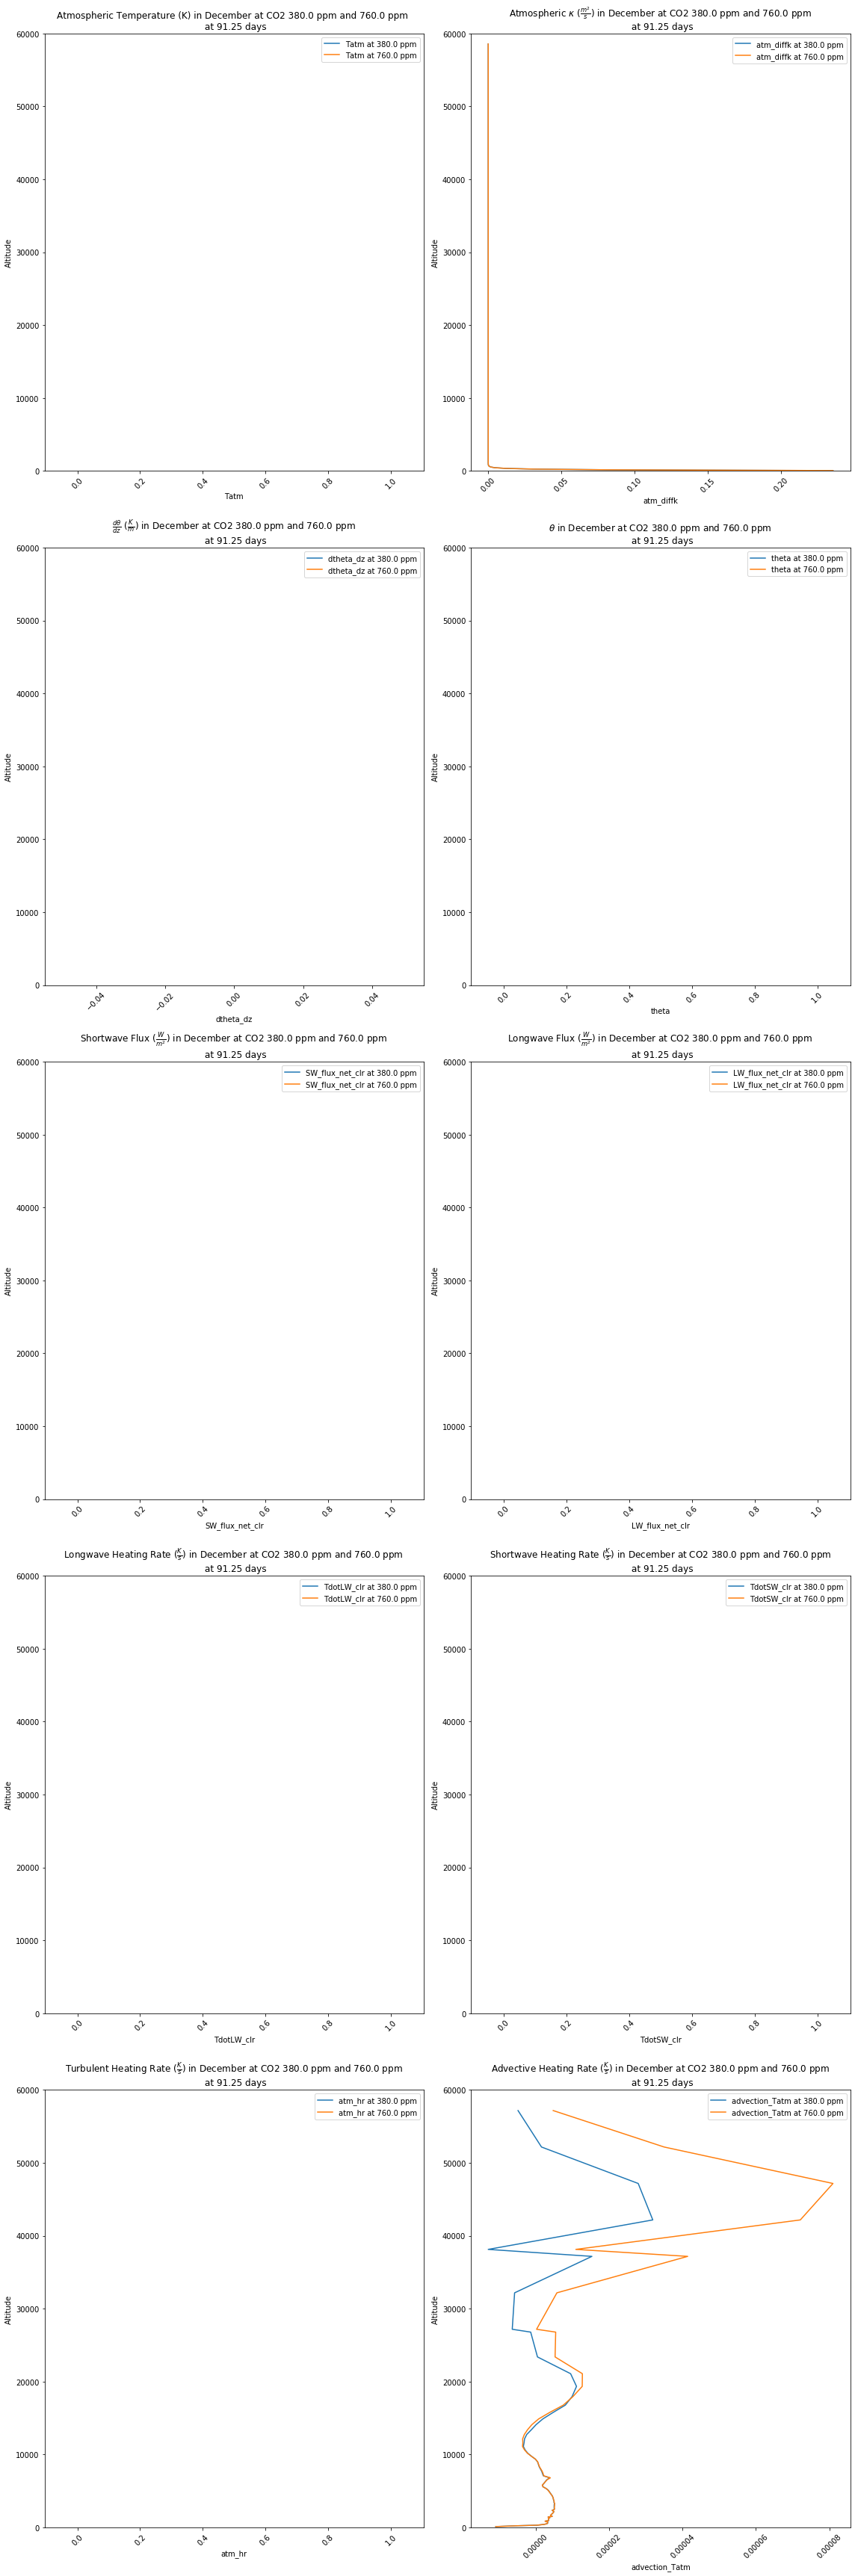

In [664]:
plotting.plot_co2_dif(
    results_dict, 
    outputs = ['Tatm','atm_diffk','dtheta_dz','theta','SW_flux_net_clr','LW_flux_net_clr','TdotLW_clr','TdotSW_clr','atm_hr','advection_Tatm'],
    output_dict = output_dict, CO2_conc1 = CO2_conc1,CO2_conc2 = CO2_conc2, 
    time1 = time4, month = month1 ,figsize = [16,48], rows =5, columns =2, ylim = 60000, diff_only = False
)
#plt.savefig(f'../figures/{month}_dif_only_CO2_1000m.png', bbox_inches = 'tight', dpi = 150)

#### time difference plots

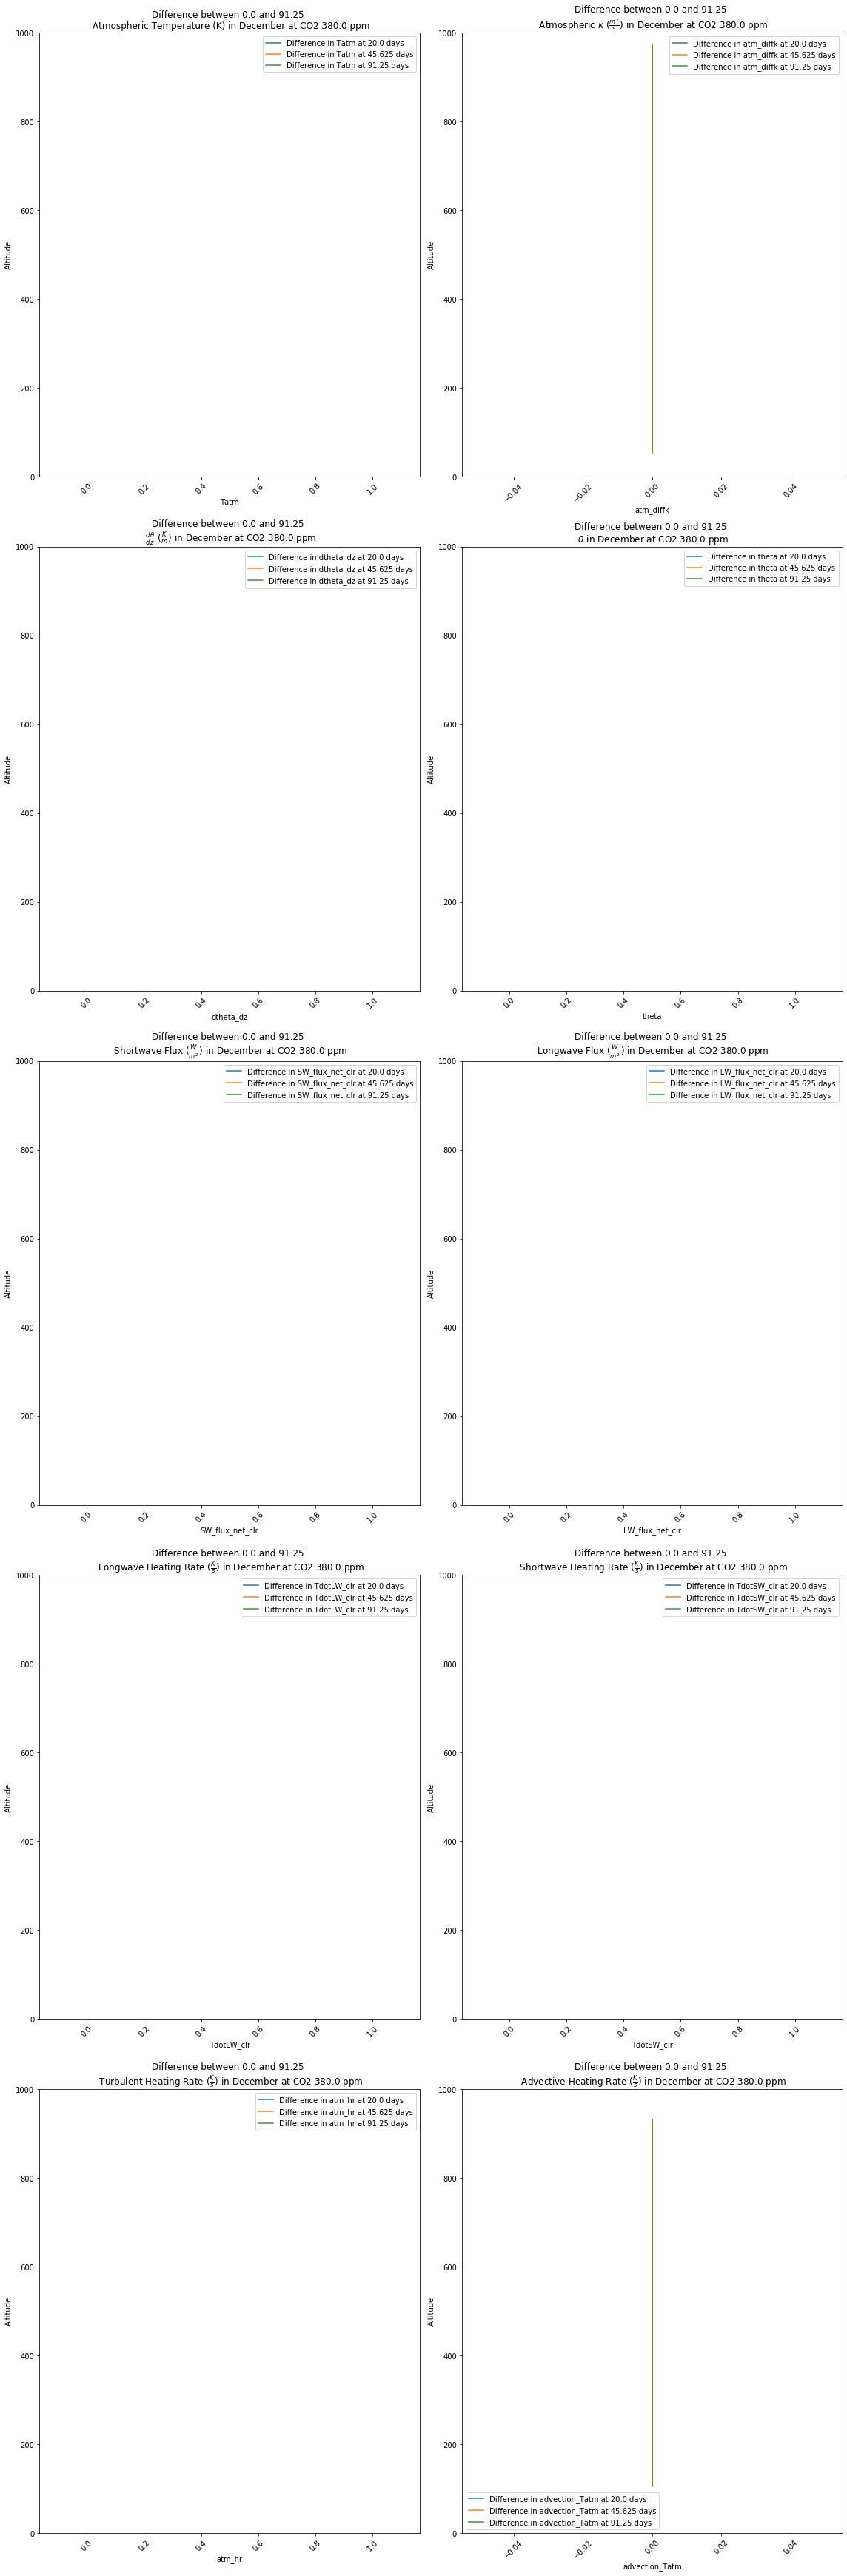

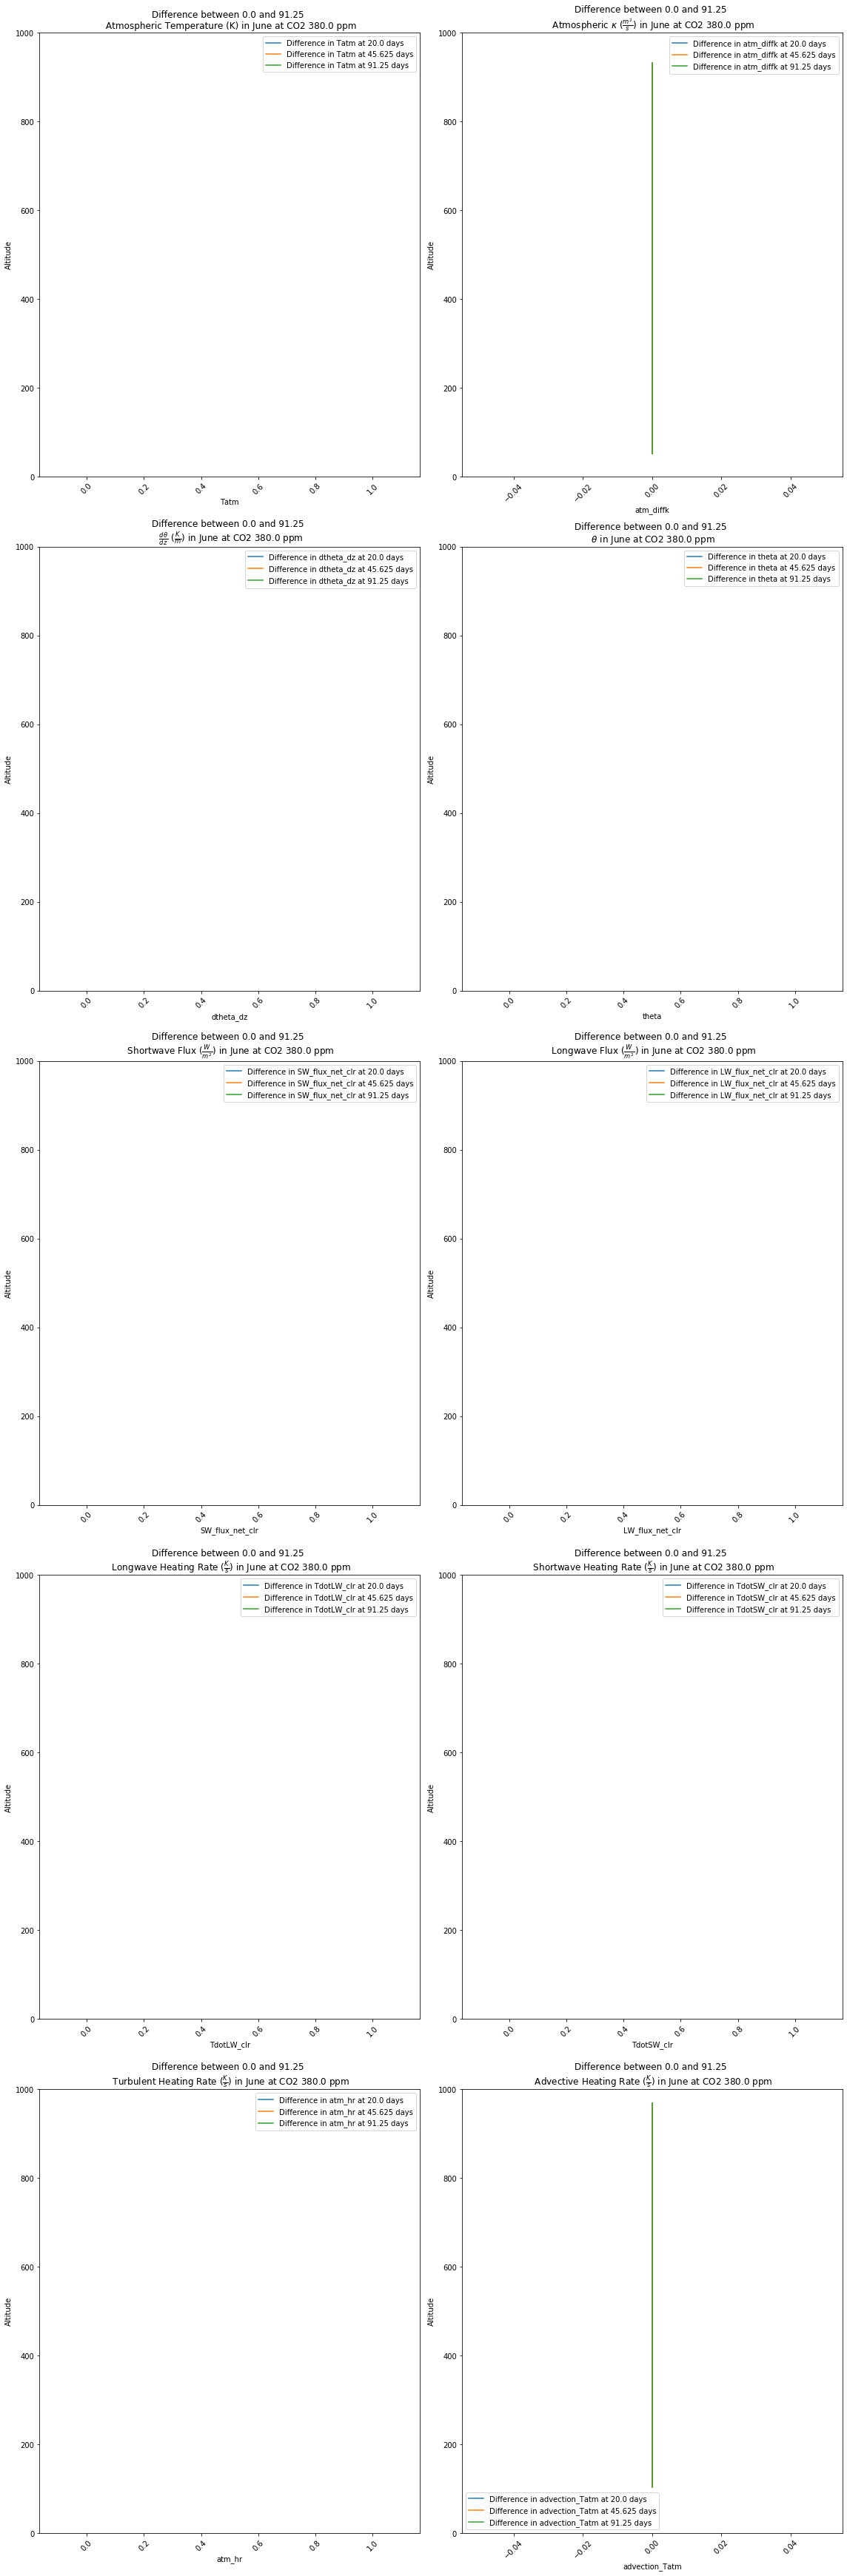

In [666]:
for month in [month1, month2]:
    plotting.plot_time_dif(
        results_dict,
        outputs = ['Tatm','atm_diffk','dtheta_dz','theta','SW_flux_net_clr','LW_flux_net_clr','TdotLW_clr','TdotSW_clr','atm_hr','advection_Tatm'],
        output_dict = output_dict, CO2_conc1 = CO2_conc1, time1 = time1, timesteps = [time2, time3, time4], month = month,
        figsize = [16,96], rows =10, columns =2, ylim = 1000, diff_only = True
                           )
#plt.savefig(f'../figures/{month}_time_dif_1000m.png', bbox_inches = 'tight', dpi = 150)

#### look at where Ts> Tatm lowest level

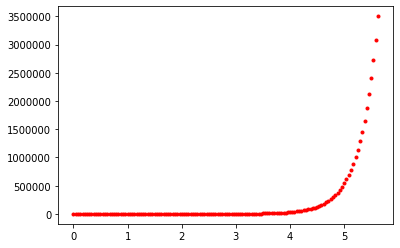

In [667]:
for idx, time in enumerate(range(0,steps*timestep, timestep)):
    plt.plot(np.round(idx*timestep/climlab.constants.seconds_per_day, 2), results_dict[time]['Tatm'][CO2_conc1][month][-1] - results_dict[time]['Ts'][CO2_conc1][month][-1], 'r.')
    #print((np.round(idx*timestep/climlab.constants.seconds_per_day, 2), results_dict[time]['Tatm'][CO2_conc1][month][-1] - results_dict[time]['Ts'][CO2_conc1][month][-1]))

#### single level process plots: 

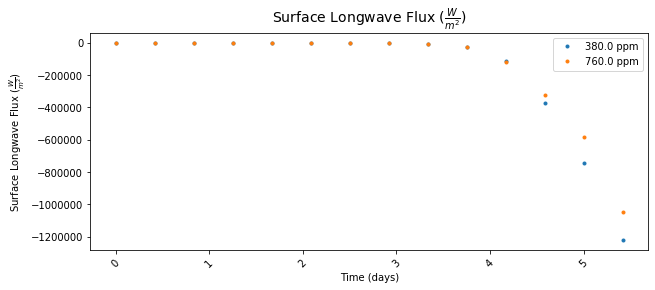

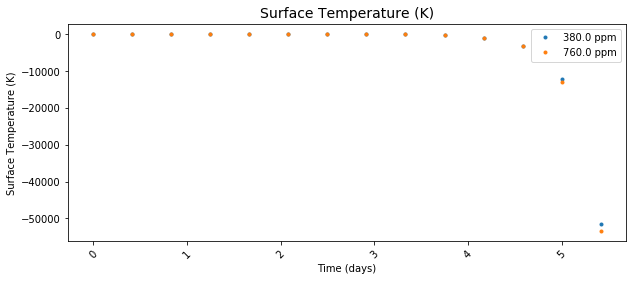

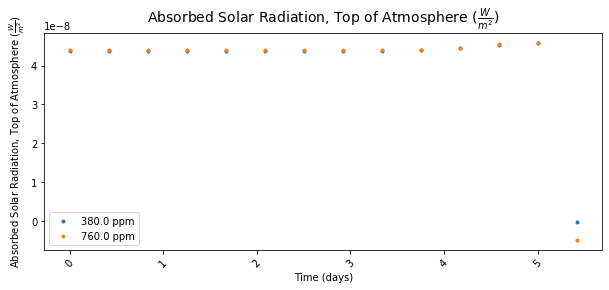

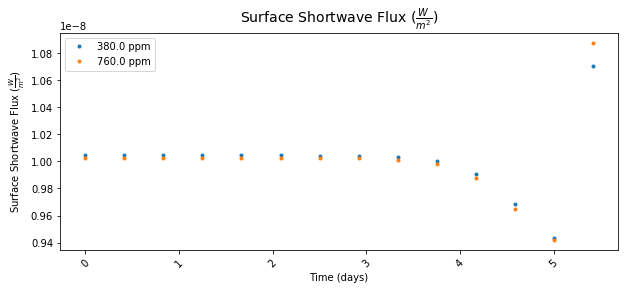

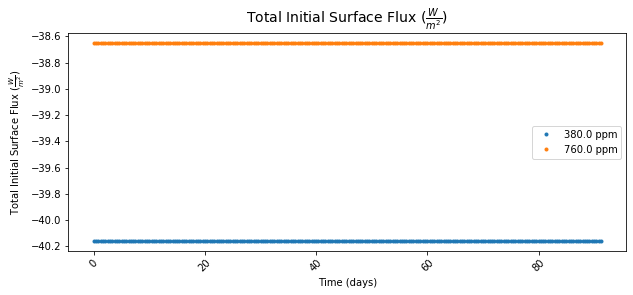

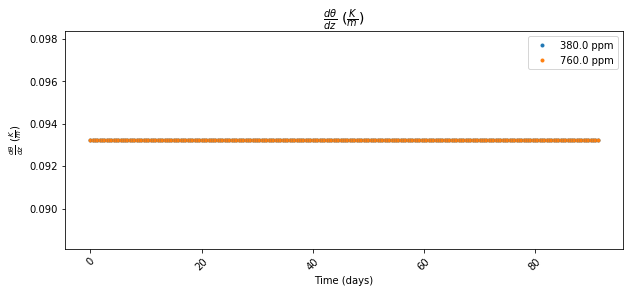

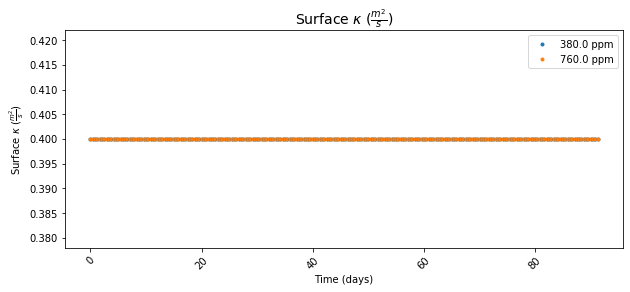

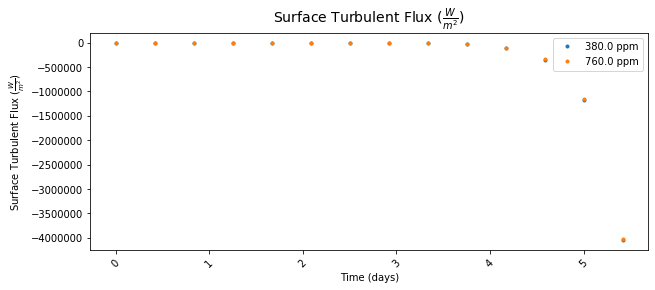

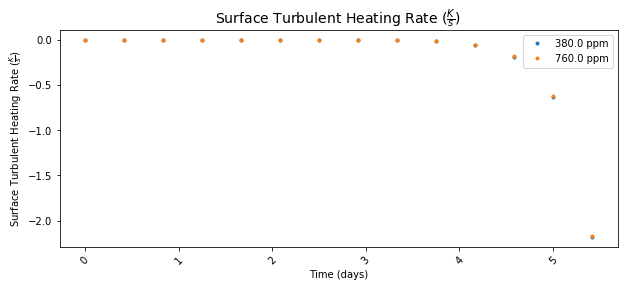

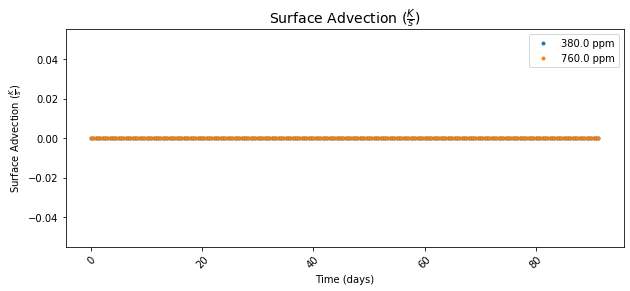

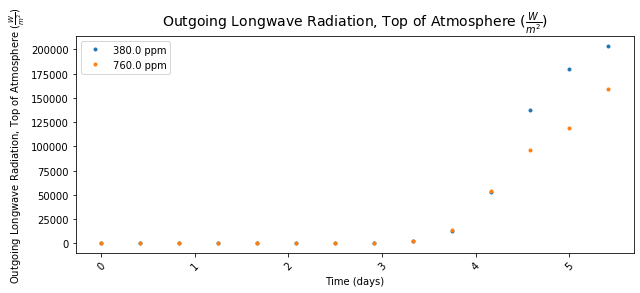

In [660]:
for process in single_level_process.keys():
    plotting.single_level_plot(results_dict,process, CO2_conc1, CO2_conc2, month2)
    plt.ylabel(single_level_process[process])
    plt.title(single_level_process[process], fontsize = 14)
    plt.savefig(f'../figures/{month1}_{process}_{CO2_conc1}_{CO2_conc2}_{steps}steps.png', bbox_inches = 'tight', dpi = 150)

#### sum of heating rates

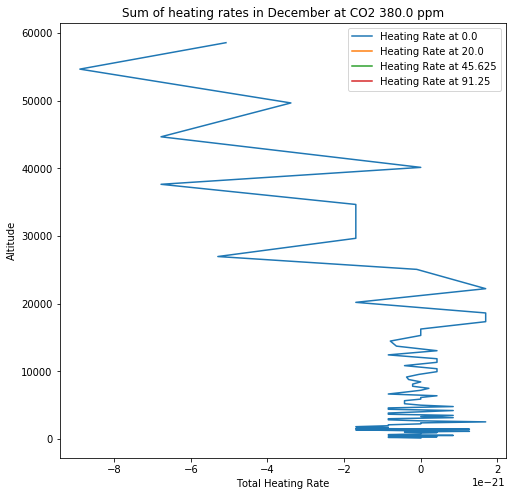

In [661]:
### plot the sum of our heating rates
month = month1
fig = plt.figure(figsize = [8,8])

ax = fig.add_subplot(1, 1, 1)
for time in [time1, time2, time3, time4]:
    x1 = np.asarray(results_dict[time]['TdotLW_clr'][CO2_conc1][month]/86400) + np.asarray(results_dict[time]['TdotSW_clr'][CO2_conc1][month]/86400) + np.asarray(results_dict[time]['atm_hr'][CO2_conc1][month]) + np.asarray((results_dict[time]['advection_Tatm'][CO2_conc1][month]))

    y1 = results_dict[time]['z_bounds'][CO2_conc1][month][:-1]

    plt.plot(x1, y1, label = f'Heating Rate at {time/climlab.constants.seconds_per_day}');

    plt.legend()
plt.ylabel('Altitude')
plt.xlabel(f'Total Heating Rate')
plt.title(f'Sum of heating rates in {month} at CO2 {CO2_conc1 * 1e6} ppm')
plt.savefig(f'sum_heating_rates{time1}_{time2}_{CO2_conc1}.png', bbox_inches = 'tight',dpi = 150)

### which is better to calculate the surface turbulent flux-- atm diffk or sfc diffk?

In [598]:
(results_dict[time1]['atm_diffk'][CO2_conc1]['July'] * results_dict[time1]['dtheta_dz'][CO2_conc1]['July'] * 1003 * 1.05)[-1]

-2.957839664824472

In [599]:
(results_dict[time1]['surface_diffk'][CO2_conc1]['July'] * results_dict[time1]['dtheta_dz'][CO2_conc1]['July'] * 1003 * 1.05)[-1]

-4.9543162132061935

### find entire column energy balance

In [647]:
#time we're looking at
time = time4
month = month2
#TOA Frad
F_rad_toa = np.asarray(results_dict[time]['OLR'][CO2_conc1][month]) - np.asarray(results_dict[time]['ASR'][CO2_conc1][month]) #W/m2

#Surface Frad
F_rad_sfc = np.asarray(results_dict[time]['LW_sfc_clr'][CO2_conc1][month]) - np.asarray(results_dict[time]['SW_sfc_clr'][CO2_conc1][month]) #W/m2

#Surface Fturb
F_turb_sfc = np.asarray(results_dict[time]['sfc_turbulent_flux'][CO2_conc1][month]) #W/m2

#dT/dt
total_atm_hr = ((np.asarray(results_dict[time4]['Tatm'][CO2_conc1][month]) - 
                np.asarray(results_dict[time4 - timestep]['Tatm'][CO2_conc1][month]))/np.asarray(timestep)) #K/s

#dz
delta_z = np.diff(results_dict[time]['z'][CO2_conc1][month]) #surface to atmosphere #m

#heat capacity (density*cp)
R = 8.314 #J/mol/K
MW_air = 0.0289647 #kg/mol
pressure_TOA = 100*ram_dict[CO2_conc1][month].lev[-1] #pascal (kg/m/s2)
density_atm = (MW_air*100*ram_dict[CO2_conc1][month].lev)/(np.asarray(results_dict[time]['Tatm'][CO2_conc1][month]) * R) #kg/m^3
density_ice = 900 #kg/m^3
cp_ice = 2060 #specific heat of ice J/kg/K
cp_air = 1003 #specific heat of air (at 250 K) J/(kg*K)
heat_capacity_atm = density_atm*cp_air
heat_capacity_sfc = density_ice*cp_ice

#atmospheric heat content rate at each level
total_atm_heat_content_rate = total_atm_hr * heat_capacity_atm * delta_z #W/m2

#advective flux at each level
total_adv_flux = np.asarray(results_dict[time]['advection_Tatm'][CO2_conc1][month]) * heat_capacity_atm * delta_z #W/m2

In [648]:
energy_budget = {}
energy_budget[month] = F_rad_toa - F_rad_sfc - F_turb_sfc + total_atm_heat_content_rate.sum() + total_adv_flux.sum()
print(F_rad_toa, F_rad_sfc, F_turb_sfc, total_atm_heat_content_rate.sum(),total_adv_flux.sum())
energy_budget


[96.13874003] [11.78751254] 3.5616385887497475 2.4387497864936045 -86.84478673051431


{'June': array([-3.61644805])}

#### solar insolation

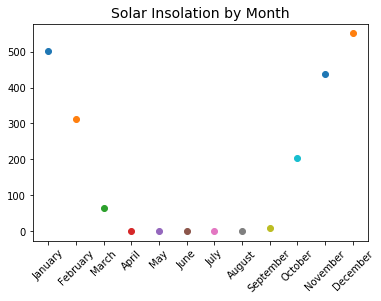

In [79]:
###plot solar insolation by month

fig, ax = plt.subplots(figsize = [6,4])
for m in np.array(ds['month']):
    plt.plot(m, ram_dict[.00038][m].subprocess.Radiation.insolation, 'o')
    plt.xticks(rotation = 45)
    plt.title('Solar Insolation by Month', fontsize = 14)